In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.argv=[''] 
del sys

In [3]:
cd "/root/SymmNeRF-baseline/code"

/root/SymmNeRF-baseline/code


In [4]:
from opt import config_parser
import setproctitle 
parser = config_parser()
args = parser.parse_args()

args.num_local_layers = 2
args.local_rank = 1
args.no_load_opt = True
args.no_load_scheduler = True
args.local_feature_ch = 1024

det = args.det
lindisp = args.lindisp

device = f'cuda:{args.local_rank}'

setproctitle.setproctitle('[Gaetan - ResNetMLP NeRF]')

#### Create a batch for testing purpose. 

In [5]:
from datasets import dataset_dict, create_training_dataset
from torch.utils.data import DataLoader 

bs = 2

train_dataset, train_sampler = create_training_dataset(args)
train_loader = DataLoader(train_dataset,batch_size = bs , sampler = train_sampler,shuffle=True)

[Info] Training dataset: srns_dataset
[Info] Loading SRNs dataset: /data/srn_cars/cars_train


#### Model instantiation

In [6]:
from model import model_dict
args.cosine_mod ={"use":False,
                   'type_mod':None,
                   "learn_through_hypernetwork":False,
                   "G": None}
args.use_ray_transformer = False

# Not use anymore the Hypernetwork to predict the NeRF layers. 
args.discard_hypernetworks = True
model = model_dict['hypernerf_symm_local'](args,ckpts_folder = "")

[Info] No ckpts found, training from scratch...


In [8]:
from model.sample_ray import RaySampler
from utils.general import cycle

# Get another iteration on the Dataloader
it = iter(train_loader)
train_batch = it.next()

# RaySampler class instantiation.
ray_sampler = RaySampler(train_batch) 

# Number of rays and number of points sampled alogn each ray.
nb_rays = 64
nb_sampled_points_on_rays = 256

# Build up a batch of ray. 
ray_batch = ray_sampler.random_sample(nb_rays,use_bbox = True,device = device)

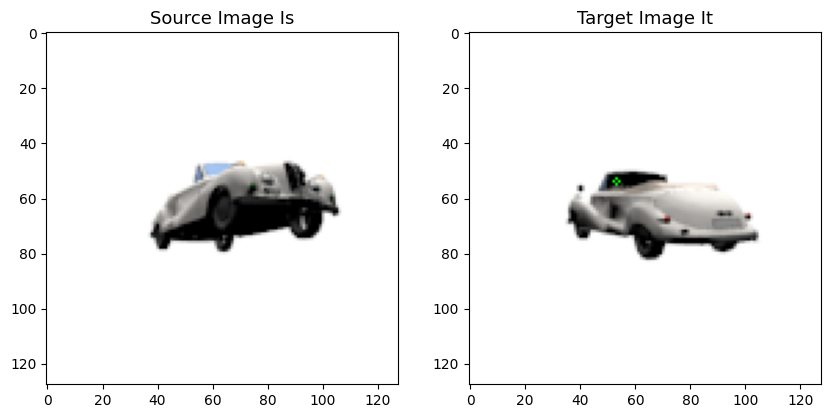

[INFO] - Sampled RGB value on the target image: [0. 0. 0.]


In [15]:
### Print out the source and target image we considering. (lets say the first image of the batch)
import matplotlib.pyplot as plt
import torch 
import numpy as np 
import cv2

H,W = 128,128
img_tot_pix = H*W
selected_ray = np.random.randint(nb_rays)


# Source image.
src_img = torch.permute(ray_batch['src_img'][0,:],(1,2,0)).cpu().numpy()

# Target one.
idx_tgt_img = ray_batch['pixs'][0][...,0][selected_ray]   # [0] for the first instance of the batch - [...,0] to get all the images index that were sampled. - [selected_ray] the selected ray 
tgt_img_flatten = ray_sampler.rgb_gt[0][img_tot_pix*idx_tgt_img:img_tot_pix*idx_tgt_img+img_tot_pix]
tgt_img = torch.reshape(tgt_img_flatten,(H,W,3)).cpu().numpy()
tgt_img_plot = tgt_img.copy()

### Retrieve the pixel that was sampled on the target image.
pix_tgt = ray_batch['pixs'][0][...,1:][selected_ray].cpu().numpy() # 0-X height / 1-Y width.
rgb_tgt = ray_batch['rgb'][0][selected_ray]

tgt_img_plot =cv2.circle(tgt_img_plot,(pix_tgt[1],pix_tgt[0]),1,(0,1.,0))


## Plot.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(src_img)
ax2.imshow(tgt_img_plot)

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)

plt.show()
print(f'[INFO] - Sampled RGB value on the target image: {rgb_tgt.cpu().numpy()}')

#### 1. Instantiate a model, without any weights loading. 

### Ensure sampling over the RGB image is correctly performed.

In [16]:
from model.render_ray import sample_along_camera_ray

rays_o = ray_batch['rays_o']    # [B,256,3]
rays_d = ray_batch['rays_d']    # [B,256,3]
z_near = ray_batch['z_near']
z_far = ray_batch['z_far']

noise = False 

#### 1. Get the 3D points ray, the viewdir and z sampled dist.
pts, viewdirs, z_vals = sample_along_camera_ray(rays_o=rays_o,  # pts : [B,256,64,3] - viewdirs : [B,256,3] - z_vals : [B,256,64]
                                                rays_d=rays_d,
                                                z_near=z_near,
                                                z_far=z_far,
                                                device=device,
                                                N_samples=nb_sampled_points_on_rays,
                                                lindisp=lindisp, 
                                                det=det)

_ = model.encode(ray_batch['src_img'])

#### 2. Get the sampled features (from the F and the source RGB image) 
ret_features = model.feature_net.index(pts,ray_batch)


#### 3. Retrieve the right feature and rgb sampling location.
ret_rgb = ret_features['rgb'].reshape(2,nb_rays,nb_sampled_points_on_rays,3)
ret_uv = ret_features['uv'].squeeze(2).reshape(2,nb_rays,nb_sampled_points_on_rays,2)
ret_uv_symm = ret_features['uv_symm'].squeeze(2).reshape(2,nb_rays,nb_sampled_points_on_rays,2)
ret_uv_symm_new = ret_features['uv_new_symm'].squeeze(2).reshape(2,nb_rays,nb_sampled_points_on_rays,2)

selected_rgb = ret_rgb[0,selected_ray,:,:]
selected_uv = ret_uv[0,selected_ray,:,:]
selected_uv_symm = ret_uv_symm[0,selected_ray,:,:]
selected_uv_symm_new = ret_uv_symm_new[0,selected_ray,:,:]

#model.feature_net.latent_scaling = torch.Tensor([2.0317,2.0317])

selected_uv_denormalized = ((selected_uv +1.)*(H /2.0)).type(torch.int16).cpu().numpy()
selected_uv_symm_denormalized = ((selected_uv_symm +1.)*(H / 2.0)).type(torch.int16).cpu().numpy()
selected_uv_symm_new_denormalized = ((selected_uv_symm_new +1.)*(H / 2.0)).type(torch.int16).cpu().numpy()

#### 4. Get the feature map. 
F = model.feature_net.latent[0,:] # only consider the first image from the batch

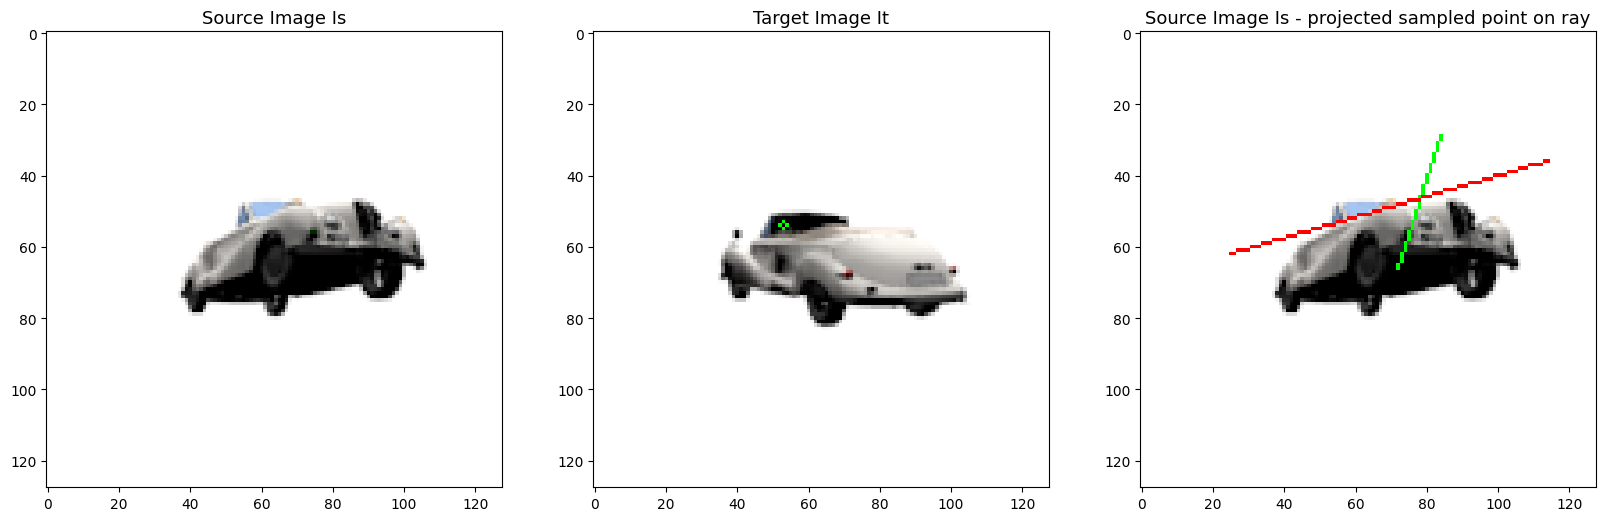

[INFO] - Sampled RGB value on the target image: [0. 0. 0.]


In [17]:
# Plot on the source image. 
src_img_plot = src_img.copy()

#src_img_plot[selected_uv_denormalized[...,1],selected_uv_denormalized[...,0],:] = (0.,1.,0.)
#src_img_plot[selected_uv_symm_denormalized[...,1],selected_uv_symm_denormalized[...,0],:] = (1.,0.,0.)
#src_img_plot[selected_uv_symm_new_denormalized[...,1],selected_uv_symm_new_denormalized[...,0],:] = (0.,0.,1.)



line_thickness = 1
x1,y1 = selected_uv_denormalized[0,:]
x2,y2 = selected_uv_denormalized[-1,:]
cv2.line(src_img_plot, (x1, y1), (x2, y2), (0., 1., 0.), thickness=line_thickness)


x1,y1 = selected_uv_symm_denormalized[0,:]
x2,y2 = selected_uv_symm_denormalized[-1,:]
cv2.line(src_img_plot, (x1, y1), (x2, y2), (1., 0., 0.), thickness=line_thickness)


x1,y1 = selected_uv_symm_new_denormalized[0,:]
x2,y2 = selected_uv_symm_new_denormalized[-1,:]
cv2.line(src_img_plot, (x1, y1), (x2, y2), (0., 0., 1.), thickness=line_thickness)


fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

im1 = ax1.imshow(src_img)
im2 = ax2.imshow(tgt_img_plot)
im3 = ax3.imshow(src_img_plot,label='baseline')

ax1.set_title('Source Image Is', fontsize=13)
ax2.set_title('Target Image It', fontsize=13)
ax3.set_title('Source Image Is - projected sampled point on ray', fontsize=13)
plt.show()
print(f'[INFO] - Sampled RGB value on the target image: {rgb_tgt.cpu().numpy()}')

#### Plot the feature map

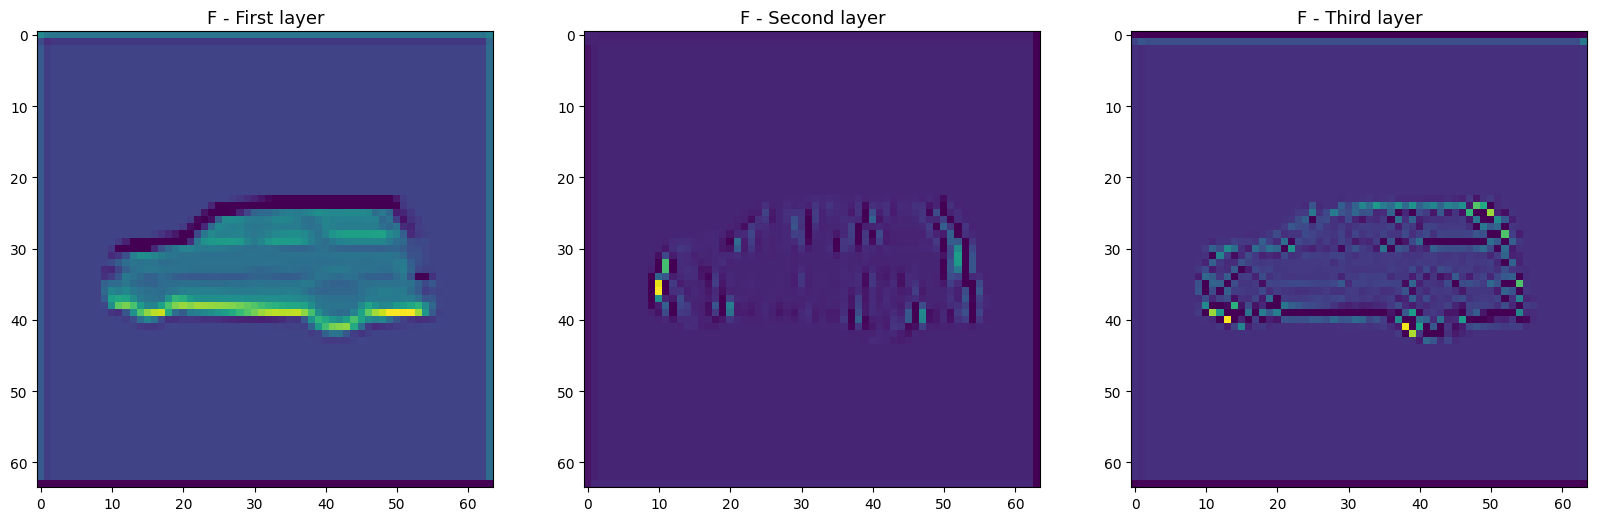

In [34]:
F_three_first = F[:3,:,:]
F_plot = F_three_first.cpu().detach().numpy().transpose((1,2,0))

fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))

im1 = ax1.imshow(F_plot[:,:,0])
im2 = ax2.imshow(F_plot[:,:,1])
im3 = ax3.imshow(F_plot[:,:,2])

ax1.set_title('F - First layer', fontsize=13)
ax2.set_title('F - Second layer', fontsize=13)
ax3.set_title('F - Third layer', fontsize=13)
plt.show()


In [38]:
64*64*512

2097152

In [ ]:
#### 2. Get the NeRF weights according to the latent code z. 
nerf_fine_layers = model.hypernetwork_fine(z) 

### 3. Get the local feature, corresponding grid and their symetric counterpart.
ret_features = model.feature_net.index(pts, 
                                       ray_batch['src_pose'],
                                       ray_batch['intrinsics'], 
                                       ray_batch['image_size'], 
                                       noise)

f, f_s = ret_features['feat'], ret_features['feat_s']
grid,grid_s = ret_features['uv'],ret_features['uv_symm']

local_feature = torch.cat([f,f_s],-1)
### 4. Compute cosine simmilarity. 
cs = compute_cosine_simmilarity(f,f_s,args.cosine_mod['G'])
args.cosine_mod['cs']=cs

### 5. Define the NeRF models (one for each image in the batch since they all have a different latent code z). 
nerf_fine = lambda x: run_nerf_symm_local(x, 
                                          nerf_layers=nerf_fine_layers, 
                                          input_ch=model.input_ch,
                                          input_ch_views=model.input_ch_views,
                                          local_feature_ch=1024,
                                          cosine_mod = args.cosine_mod
                                         )

network = {'nerf':nerf_fine,
          'ray_transformer':model.ray_transformer}

print(f'Shape of pts: {pts.shape}')
raw_fine = run_network(pts,viewdirs,network,model.embed_fn,model.embeddirs_fn,local_feature,args.cosine_mod,ret_features)